# 💳 Credit Card Fraud Detection: Sızıntısız ve İş Odaklı AI Modeli

Bu teknik rapor, kredi kartı dolandırıcılık tespiti projesinin uçtan uca analiz sürecini, veri mühendisliği kararlarını ve modelleme stratejisini belgelemektedir.

### 🎯 Projenin İş Hedefi
Veri setindeki dolandırıcılık oranı sadece **%0.17**'dir. Standart modeller bu nadir olayları gözden kaçırma eğilimindedir.
Amacımız:
1.  **High Recall:** Dolandırıcılık vakalarının tamamına yakınını yakalamak.
2.  **Precision Dengesi:** Yanlış alarmları (müşteri memnuniyetsizliği) minimize etmek.
3.  **Data Leakage Prevention:** Test verisini tamamen izole ederek gerçekçi sonuçlar almak.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Görselleştirme Ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## 1. Veri Hazırlığı ve Kritik Sıralama
Dolandırıcılık tespitinde **"İşlem Hızı"** (Velocity) çok güçlü bir belirleyicidir. Bir kartın saniyeler içinde birden fazla işlem yapması şüphelidir.
Bu hızı (`Time_Diff`) doğru hesaplayabilmek için verinin **kronolojik (zaman) sırasına göre** dizili olması zorunludur. Rastgele karıştırılmış (shuffled) veride bu özellik hatalı hesaplanır.

In [2]:
# Veri yolunu dinamik belirliyoruz
data_path = os.path.join('..', 'data', 'creditcard.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    # KRİTİK ADIM: Veriyi işlem zamanına göre sırala
    df = df.sort_values('Time')
    print(f"Veri Seti Yüklendi: {df.shape}")
else:
    print("HATA: Veri dosyası bulunamadı. Lütfen 'data' klasörünü kontrol edin.")

df.head()

Veri Seti Yüklendi: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. İleri Seviye Özellik Mühendisliği (Advanced Feature Engineering)
Ham verideki `Time` ve `Amount` sütunları model için yeterli değildir. İş mantığına dayalı yeni değişkenler türetiyoruz:

* **`Time_Diff` (Hız Kontrolü):** Bir önceki işlemle arasındaki saniye farkı. Süre kısaldıkça risk artar.
* **`Is_Night` (Zamanlama):** Dolandırıcılar genellikle banka takibinin az olduğu gece saatlerini (22:00 - 06:00) tercih edebilir.
* **`Amount_Log` (Normalizasyon):** İşlem tutarları arasındaki devasa farkları ($1 vs $10.000) logaritmik ölçekle dengeliyoruz.
* **`PCA_Stats` (Sıradışılık):** Gizli bileşenlerin (V1-V28) istatistiksel sapmaları, işlemin "tuhaflığını" ölçer.

In [3]:
def create_features_advanced(dataframe):
    df_copy = dataframe.copy()

    # 1. Logaritmik Tutar Dönüşümü
    df_copy['Amount_Log'] = np.log1p(df_copy['Amount'])

    # 2. İşlem Hızı (Time_Diff) - Veri sıralı olduğu için doğru çalışır
    df_copy['Time_Diff'] = df_copy['Time'].diff().fillna(0)

    # 3. Saat ve Gece/Gündüz Analizi
    df_copy['Hour'] = (df_copy['Time'] // 3600) % 24
    df_copy['Is_Night'] = df_copy['Hour'].apply(lambda x: 1 if (x < 6 or x >= 22) else 0)

    # 4. PCA Bileşenlerinden İstatistik Türetme
    pca_cols = [col for col in df_copy.columns if col.startswith('V')]
    df_copy['PCA_Abs_Mean'] = df_copy[pca_cols].abs().mean(axis=1)
    df_copy['PCA_Pos_Sum'] = df_copy[pca_cols].apply(lambda x: x[x > 0].sum(), axis=1)
    df_copy['PCA_Neg_Sum'] = df_copy[pca_cols].apply(lambda x: x[x < 0].sum(), axis=1)

    # Modelde kullanılmayacak ham sütunları çıkar
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)

    return df_copy

# Fonksiyonu TÜM veriye uyguluyoruz
df_final = create_features_advanced(df)
print("Özellik mühendisliği tamamlandı.")
df_final.head()

Özellik mühendisliği tamamlandı.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V27,V28,Class,Amount_Log,Time_Diff,Hour,Is_Night,PCA_Abs_Mean,PCA_Pos_Sum,PCA_Neg_Sum
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.133558,-0.021053,0,5.014760,0.0,0.0,1,0.470935,8.133975,-5.052218
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.008983,0.014724,0,1.305626,0.0,0.0,1,0.333822,6.893371,-2.453645
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.055353,-0.059752,0,5.939276,1.0,0.0,1,0.855171,12.518050,-11.426739
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.062723,0.061458,0,4.824306,0.0,0.0,1,0.592045,7.083832,-9.493428
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.219422,0.215153,0,4.262539,1.0,0.0,1,0.539101,10.236775,-4.858047


## 3. Sızıntısız Pipeline ve Hibrit Modelleme (Ensemble Learning)

### Veri Sızıntısı (Data Leakage) Önlemi
En büyük hatalardan biri, SMOTE (yapay veri üretimi) işlemini tüm veriye uygulamaktır. Bu projede **`ImbPipeline`** kullanılarak, SMOTE sadece eğitim (train) setine uygulanmış, test seti tamamen saf bırakılmıştır.

### Model Mimarisi: Voting Classifier
Tek bir algoritmaya güvenmek yerine, üç güçlü modelin "ortak aklı" kullanılmıştır:
1.  **XGBoost:** Yüksek performans ve hız.
2.  **LightGBM:** Dengesiz veri setlerinde kararlı.
3.  **Random Forest:** Varyansı düşürür ve genellemeyi artırır.

In [4]:
# 1. Veriyi Bölme (Stratified Split: Sınıf oranlarını korur)
X = df_final.drop('Class', axis=1)
y = df_final['Class']

# Test seti (%20) modele HİÇ gösterilmeyecek
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=17, stratify=y
)

# 2. Modellerin Tanımlanması
xgb = XGBClassifier(eval_metric='logloss', random_state=17)
lgbm = LGBMClassifier(verbosity=-1, random_state=17)
rf = RandomForestClassifier(max_depth=5, random_state=17)

# 3. Oylama Mekanizması (Soft Voting: Olasılıkların ortalamasını alır)
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf)],
    voting='soft'
)

# 4. Sızıntısız Pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),       # Veriyi ölçekle
    ('smote', SMOTE(random_state=17)),  # Sadece eğitim setini dengele
    ('classifier', voting_clf)          # Modeli eğit
])

print("Model eğitimi başladı... (Bu işlem birkaç dakika sürebilir)")
# Çıktı kalabalığını önlemek için _ değişkenine atıyoruz
_ = pipeline.fit(X_train, y_train)
print("Eğitim tamamlandı!")

Model eğitimi başladı... (Bu işlem birkaç dakika sürebilir)
Eğitim tamamlandı!


## 4. İş Odaklı Karar Mekanizması: Threshold Optimization
Varsayılan olarak modeller `%50` ihtimalin üzerini dolandırıcılık sayar. Ancak bankacılıkta bir dolandırıcılığı kaçırmanın maliyeti (Müşteri güveni + Para kaybı), yanlış alarm vermekten çok daha yüksektir.

Bu yüzden **Recall (Yakalama Oranı)** maksimize edilmek istenmiştir. Eşik değer (Threshold) **`0.05`** seviyesine çekilerek, modelin en ufak şüphede bile alarm vermesi sağlanmıştır.

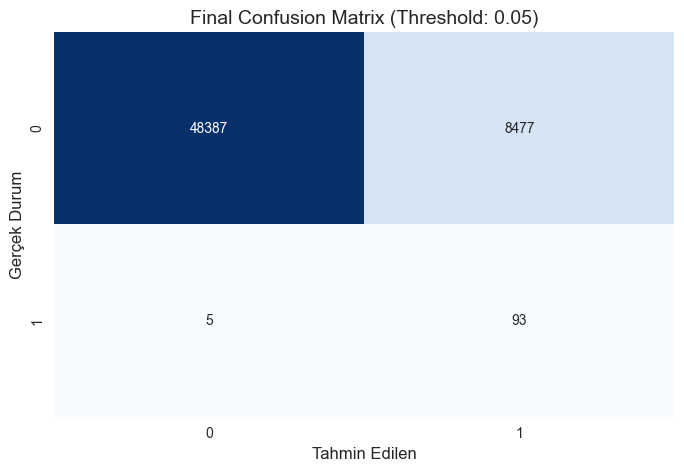


=== SINIFLANDIRMA RAPORU ===
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     56864
           1       0.01      0.95      0.02        98

    accuracy                           0.85     56962
   macro avg       0.51      0.90      0.47     56962
weighted avg       1.00      0.85      0.92     56962


ÖZET: Test setindeki toplam 98 dolandırıcılık vakasından
Başarıyla yakalanan: 93
Kaçırılan: 5


In [5]:
# Olasılık Tahminleri
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Optimize Edilmiş Eşik Değer
threshold = 0.05
y_pred = (y_proba >= threshold).astype(int)

# --- Görselleştirme ---
plt.figure(figsize=(8, 5))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Final Confusion Matrix (Threshold: {threshold})', fontsize=14)
plt.xlabel('Tahmin Edilen', fontsize=12)
plt.ylabel('Gerçek Durum', fontsize=12)
plt.show()

# Detaylı Rapor
print("\n=== SINIFLANDIRMA RAPORU ===")
print(classification_report(y_test, y_pred))

print(f"\nÖZET: Test setindeki toplam {sum(y_test)} dolandırıcılık vakasından")
print(f"Başarıyla yakalanan: {cm[1,1]}")
print(f"Kaçırılan: {cm[1,0]}")